In [26]:
import pandas as pd

df = pd.read_csv('dataset/in.tsv', sep='\t')
df.columns = ["file_name", "list_keys", "pdf2djvu/djvu2hocr", "tesseract", "textract", "pdf2djvu/djvu2hocr_tesseract"]
df = df.dropna(axis = 0)

In [31]:
# Choose which extracted text method to use as input
documents = df["tesseract"].tolist()
df.head()

,file_name,list_keys,pdf2djvu/djvu2hocr,tesseract,textract,pdf2djvu/djvu2hocr_tesseract
0,009fab39d746267b6de8428366fe4b02.pdf,address__post_town address__postcode address__...,"\fAnnual Report 2015-2017 July, 2017\nStepping...",\n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...,Charity Name\nNo lif anv)\nStepping Stone Thea...,\n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...
1,01c7fd563327947c68abdd9717ef228d.pdf,address__post_town address__postcode address__...,Promoting Independent Living\nCelebrating new\...,54 S ke *\nB\n \nWelcome to our Annual\nReport...,Promoting Independent Living\nAbility\nAbility...,54 S ke *\nB\n \nWelcome to our Annual\nReport...
2,01d804edf76bec4912d2466908a60889.pdf,address__post_town address__postcode address__...,Annual Repor t 8\nAccounts 2017/18\nYear ended...,Annual Report &\nAccounts 2017//183\nYear ende...,Annua Report &\nAccounts 2017/18\nYear ended 3...,Annual Repor t 8\nAccounts 2017/18\nYear ended...
3,01e4461b059e707b7d8276b3d2b80b71.pdf,address__post_town address__postcode address__...,"The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb..."
4,01f91ab7c5e0a5686a0ae1d1d4099b09.pdf,address__post_town address__postcode address__...,KEMPTON GREAT ENGINES TRUST UMITED\nFINANCIAL ...,KEMPTON GREAT ENGINES TRUST LIMITED\nFINANCIAL...,KEMPTON GREAT ENGINES TRUST LIMITED\nFINANCIAL...,KEMPTON GREAT ENGINES TRUST UMITED\nFINANCIAL ...


In [7]:
# Treatment of cleaned text: tokenisation, stemming and lemmatisation
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pickle
from rich.progress import track

def cleaning(document):
    # Load English tokenizer, tagger, parser and NER
    nlp = spacy.load("en_core_web_sm")
    # Process whole documents
    document = document.replace("\\n"," ")
    doc = nlp(document)

    # Tokenisation
    token_list = []
    for token in doc:
        token_list.append(token.text)

    # Create list of word tokens after removing stopwords
    filtered_sentence =[] 

    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
            
    doc = nlp(' '.join(filtered_sentence))

    #Lematization
    lemma_word = [] 
    for token in doc:
        lemma_word.append(token.lemma_)

    #Remove punctuation
    doc = ' '.join(word.strip(string.punctuation) for word in lemma_word)

    return doc

# Call of the function for all documents
# in_documents = [cleaning(document) for document in documents]

In [8]:
import pickle
# with open('in_documents.pkl', 'wb') as f:
#     pickle.dump(in_documents, f)

In [35]:
with open('in_documents.pkl', 'rb') as f:
    in_documents = pickle.load(f)
text = in_documents[2].lower().split(' ')
from collections import Counter
word_counts = Counter(text)
top_words = word_counts.most_common(100)
print(top_words)

[('', 4631), ('bbc', 254), ('0', 239), ('£', 231), ('media', 214), ('action', 210), ('report', 125), ('work', 114), ('2017/18', 110), ('—', 106), ('financial', 99), ('2018', 94), ('2017', 94), ('fund', 93), ('year', 86), ('annual', 81), ('statement', 78), ('total', 78), ('000', 74), ('income', 73), ('trustees', 66), ('medium', 64), ('include', 64), ('programme', 59), ('group', 58), ('m', 57), ('people', 55), ('project', 55), ('help', 53), ('development', 50), ('staff', 50), ('support', 50), ('health', 50), ('radio', 50), ('company', 49), ('cost', 47), ('activity', 46), ('country', 42), ('march', 41), ('organisation', 40), ('charity', 40), ('india', 40), ('charitable', 38), ('3', 37), ('risk', 37), ('provide', 37), ('expenditure', 37), ('member', 36), ('service', 35), ('asset', 35), ('scheme', 35), ('world', 34), ('nepal', 34), ('uk', 33), ('community', 33), ('office', 33), ('board', 32), ('basis', 32), ('information', 31), ('policy', 29), ('grant', 29), ('young', 28), ('bangladesh', 27

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import pickle

with open('in_documents.pkl', 'rb') as f:
    in_documents = pickle.load(f)

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
trans = vectorizer.fit_transform(in_documents) # input must be a list of string aka whole text in one str

svd = TruncatedSVD(100)
X = svd.fit_transform(trans)

# Kmeans method
true_k = 9
model_k = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model_k.fit(X)

order_centroids = model_k.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()


In [12]:
from fcmeans import FCM
# Soft clustering Method aka c-means clustering
model_c = FCM(n_clusters=6)
model_c.fit(X)

fcm_centers = model_c.centers
fcm_labels = model_c.predict(X)


In [ ]:
print(model_c.__dict__)

<AxesSubplot:>

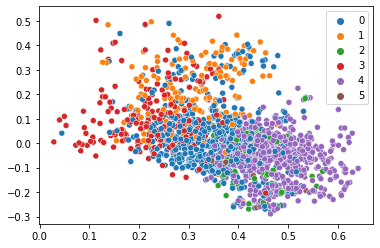

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
# Plot C-means
x = X[:,0]
y = X[:,1]
sns.scatterplot(x=x, y=y, hue=fcm_labels, palette='tab10')
# plot result
# f, axes = plt.subplots(1, 2, figsize=(11,5))
# axes[0].scatter(X[:,0], X[:,1], alpha=.1)
# axes[1].scatter(X[:,0], X[:,1], c=fcm_labels, alpha=.1)
# axes[1].scatter(fcm_centers[:,6], fcm_centers[:,6], marker="+", s=500, c='w')
# plt.show()

<AxesSubplot:>

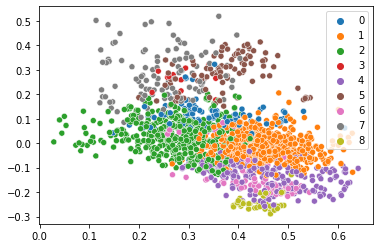

In [9]:
# Plot K-means
x = X[:,0]
y = X[:,1]
df = pd.DataFrame({'x': x,'y': y, 'model': model_k.labels_})

sns.scatterplot(x=x, y=y, hue=model_k.labels_, palette='tab10')

In [32]:
import re
pat = r' \w '
string = 'This a is test u which is not a concluding'
x = re.findall(pat, string)
print(x)

[' a ', ' u ', ' a ']


Cluster: 0


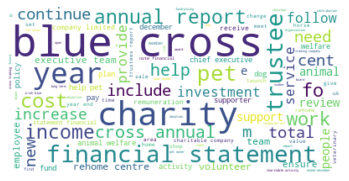

Cluster: 1


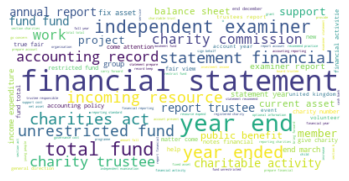

Cluster: 2


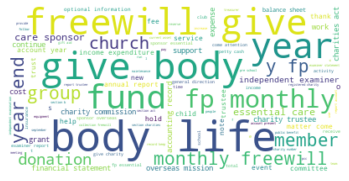

Cluster: 3


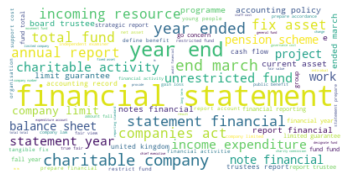

Cluster: 4


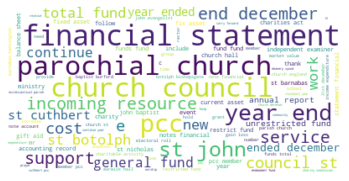

Cluster: 5


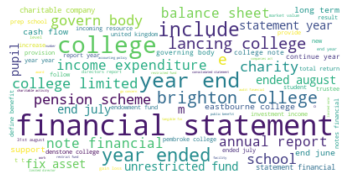

Cluster: 6


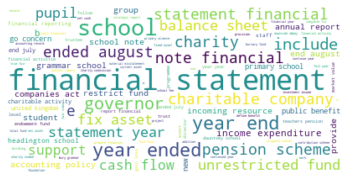

Cluster: 7


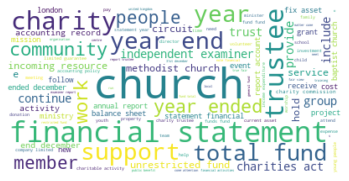

Cluster: 8


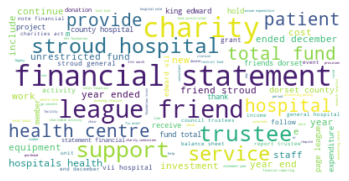

In [44]:
from wordcloud import WordCloud

result={'cluster':model_k.labels_,'wiki':in_documents}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['wiki'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()